#### Author: Rudransh Jaiswal
# Regularised Logistic Regression (with different Kernels)

Logistic Regression: $\begin{align} P(Y=1|X=x) = \sigma(w^{T}\phi(x)) \quad x\epsilon\mathbb{R}^{d} \; , \phi : \mathbb{R}^{d} \rightarrow \mathbb{R}^{d\,'} \end{align}$

- The objective to be minimised is:

$\begin{align} \min\limits_{w\,\epsilon\,\mathbb{R}^{d} } \, \frac{1}{2}\sum_{i=1}^{n} log(1+exp(-y_{i} w^{T} \phi(x_{i}))) + \frac{\lambda}{2} ||w||^{2}  \end{align}$

$\begin{align} w = \Phi^{T}\alpha \quad;\; \Phi \,\epsilon \,\mathbb{R}^{nxd\,'}\quad; \;K =\Phi \Phi^{T} \quad \end{align}$ (Kernel Matrix)

This is equivalent to:

$\begin{align} \min\limits_{\alpha\,\epsilon\,\mathbb{R}^{n} } \, \frac{1}{2}\sum_{i=1}^{n} log(1+exp(-y_{i} \alpha^{T}\Phi \phi(x_{i}))) + \frac{\lambda}{2}  \alpha^{T}\Phi \Phi^{T}\alpha \Leftrightarrow \min\limits_{\alpha\,\epsilon\,\mathbb{R}^{n} } \, \frac{1}{2}\sum_{i=1}^{n} log(1+exp(-y_{i} \alpha^{T}K_{:,i}))) + \frac{\lambda}{2}  \alpha^{T}K\alpha \end{align}$

Let's denote the objective as
$\begin{align} R(\alpha) = \frac{1}{2}\sum_{i=1}^{n} log(1+exp(-y_{i} \alpha^{T}K_{:,i}))) + \frac{\lambda}{2}  \alpha^{T}K\alpha \end{align}$

$\begin{align} \alpha^{*} = \min\limits_{\alpha\,\epsilon\,\mathbb{R}^{n} } R(\alpha)  \end{align}$

We do Gradient descent using :
$\begin{align} \nabla R(\alpha) = \frac{1}{n}\sum_{i=1}^{n} \sigma(-y_{i} \alpha^{T}K_{:,i})(-y_{i}K_{:,i}) + \lambda K\alpha \end{align}$

- For Prediction:

$\begin{align} P(Y=1|X=x) = \sigma(w^{T}\phi(x))\end{align}$

$\begin{align} \sigma(w^{T}\phi(x)) = \sigma(\alpha^{T}\Phi\phi(x)) = \sigma(\sum_{i=1}^{n} \alpha_{i}K(x_{i},x))\end{align}$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def sigm(x):
    if(x <= -100): return 0
    else: return 1/(1+np.exp(-x))
    
kern_lin = lambda x1,x2: 1+np.matmul(np.transpose(x1),x2)
kern_rbf = lambda x1,x2,gma: np.exp(-gma * (np.linalg.norm(x1-x2))**2)
kern_poly = lambda x1,x2,deg: (1+np.matmul(np.transpose(x1),x2))**deg

def Kernel_mat(kern, X, kern_para):
    n=len(X)
    K = np.zeros((n,n),dtype='float128')
    if(kern=='linear'):
        for i in range(n):
            for j in range(n):
                K[i][j] = 1+np.matmul(np.transpose(X[i]),X[j])
    elif(kern=='rbf'):
        for i in range(n):
            for j in range(n):
                K[i][j]=np.exp(-kern_para * (np.linalg.norm(X[i]-X[j]))**2)
    elif(kern=='poly'):
        for i in range(n):
            for j in range(n):
                K[i][j]= (1+np.matmul(np.transpose(X[i]),X[j]))**kern_para    
    return K

def gradR(alpha, Y, K, reg_para):
    # ∇R(α)= (1/n)*Σσ(-yi αT K:,i)(-yi K:,i) + λKα is grad descent for Kernel Log Reg.
    n=len(K)
    grad=np.zeros(n)
    for i in range(n):
        grad = grad + sigm(-Y[i]*np.dot(alpha,K[:,i]))*(-Y[i]*K[:,i])
    grad = grad + reg_para*np.matmul(K,alpha)
    grad = (1/n)*grad
    return grad

def grad_des(Y,K,reg_para,eta,no_itr):
    # α = α - η∇R(α); η = step size
    n=K.shape[0]
    alpha=np.zeros(n)
    for i in range(no_itr):
        alpha = alpha - eta*gradR(alpha,Y,K,reg_para)
    return alpha

def predLr_lin(X_train, Y_train, X_test, reg_param):
    eta=0.5
    n=len(X_train)
    K=Kernel_mat('linear', X_train, 0)
    alpha=grad_des(Y_train, K, reg_param, eta, 50) # 50 iterations of GD
    Y_pred=[]
    for j in range(len(X_test)):
        res=0
        for i in range(n):
            res=res+alpha[i]*kern_lin(X_train[i],X_test[j])
        Y_pred.append(np.sign(res))
    return np.array(Y_pred)

def predLr_rbf(X_train, Y_train, X_test, reg_param, kernal_param):
    eta=0.3
    n=len(X_train)
    K=Kernel_mat('rbf', X_train, kernal_param)
    alpha=grad_des(Y_train, K, reg_param, eta, 100)
    Y_pred=[]
    for j in range(len(X_test)):
        res=0
        for i in range(n):
            res=res+alpha[i]*kern_rbf(X_train[i],X_test[j],kernal_param)
        Y_pred.append(np.sign(res))
    return np.array(Y_pred)

def predLr_poly(X_train, Y_train, X_test, reg_param, kernal_param):
    eta=0.5
    n=len(X_train)
    K=Kernel_mat('poly', X_train, kernal_param)
    alpha=grad_des(Y_train, K, reg_param, eta, 50)
    Y_pred=[]
    for j in range(len(X_test)):
        res=0
        for i in range(n):
            res=res+alpha[i]*kern_poly(X_train[i],X_test[j],kernal_param)
        Y_pred.append(np.sign(res))
    return np.array(Y_pred)



In [32]:
def class_sep(X,Y):
    pos,neg=[],[]
    for i in range(len(X)):
        if(Y[i]==1): pos.append(X[i])
        else: neg.append(X[i])
    return np.array(pos), np.array(neg)

def meshgen(X):
    xmax,xmin=np.max(X,axis=0),np.min(X,axis=0)
    x1,x2=np.linspace(xmin[0],xmax[0],100),np.linspace(xmin[1],xmax[1],100)
    xv,yv=np.meshgrid(x1,x2)
    x1,x2=xv.reshape(10000,1),yv.reshape(10000,1)
    Xmesh=np.stack((x1, x2), axis=-1)
    Xmesh=Xmesh.reshape(10000,2)
    return np.array(Xmesh)

def plotIt(ttl, ax, X_mesh, Y_mesh_pred, X_test, Y_test):
    Xt_pos,Xt_neg=class_sep(X_test,Y_test)
    Xm_pos,Xm_neg=class_sep(X_mesh,Y_mesh_pred)
    Xt_pos,Xt_neg=np.transpose(Xt_pos),np.transpose(Xt_neg)
    Xm_pos,Xm_neg=np.transpose(Xm_pos),np.transpose(Xm_neg)
    ax.scatter(Xm_pos[0], Xm_pos[1], color='aquamarine', label='+1')
    ax.scatter(Xm_neg[0], Xm_neg[1], color='lavender', label='-1')
    ax.scatter(Xt_pos[0], Xt_pos[1], marker='.', c='green')
    ax.scatter(Xt_neg[0], Xt_neg[1], marker='.', c='darkviolet')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(ttl)
    ax.legend(loc=1)

In [25]:
dataset=np.load('./dset1.npz')
X_train=np.array(dataset[dataset.files[0]])
Y_train=np.array(dataset[dataset.files[1]])
X_test=np.array(dataset[dataset.files[2]])
Y_test=np.array(dataset[dataset.files[3]])

X_mesh=meshgen(X_test)

In [27]:
Y_mesh_pred1=predLr_lin(X_train, Y_train, X_mesh, 1e-3)

In [28]:
Y_mesh_pred2=predLr_rbf(X_train, Y_train, X_mesh, 1e-3, 1)

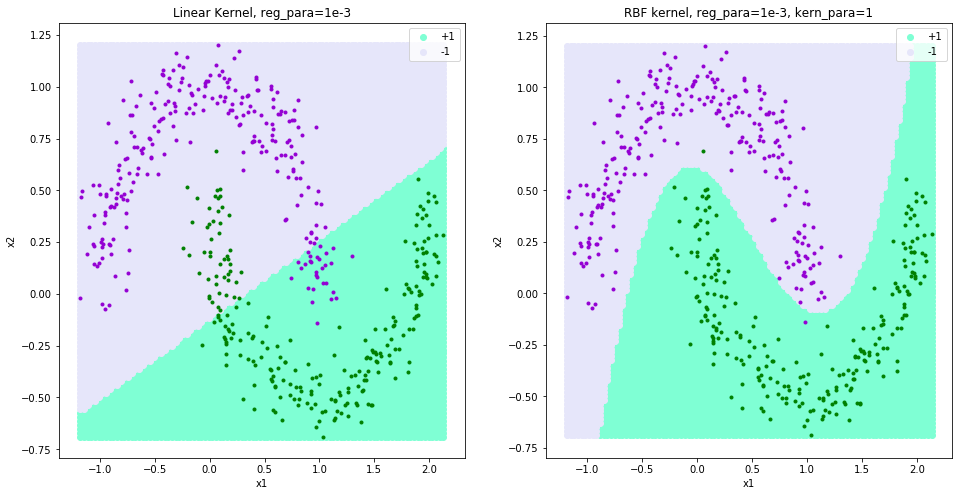

In [35]:
fig, axes= plt.subplots(figsize=(16,8),ncols=2) 
plotIt("Linear Kernel, reg_para=1e-3", axes[0], X_mesh, Y_mesh_pred1, X_test, Y_test)
plotIt("RBF kernel, reg_para=1e-3, kern_para=1", axes[1], X_mesh, Y_mesh_pred2, X_test, Y_test)